In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import wandb
from wandb.integration.xgboost import WandbCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import seaborn as sns

from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)
warnings.filterwarnings('ignore')

<font color=yellow>
1. data 불러오기
</font>

In [58]:
class cfg:
    data_path = './data'

df_train = pd.read_csv(os.path.join(cfg.data_path, 'train.csv'))
df_test = pd.read_csv(os.path.join(cfg.data_path, 'test.csv'))

df_train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


<font color=yellow>
2. 전처리 및 데이터 확인
</font>

In [59]:
# datatype 확인
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [60]:
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,20758.0,NaN,NaN,NaN,10378.5,5992.46278,0.0,5189.25,10378.5,15567.75,20757.0
Gender,20758,2,Female,10422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,20758.0,NaN,NaN,NaN,23.841804,5.688072,14.0,20.0,22.815416,26.0,61.0
Height,20758.0,NaN,NaN,NaN,1.700245,0.087312,1.45,1.631856,1.7,1.762887,1.975663
Weight,20758.0,NaN,NaN,NaN,87.887768,26.379443,39.0,66.0,84.064875,111.600553,165.057269
family_history_with_overweight,20758,2,yes,17014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAVC,20758,2,yes,18982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FCVC,20758.0,NaN,NaN,NaN,2.445908,0.533218,1.0,2.0,2.393837,3.0,3.0
NCP,20758.0,NaN,NaN,NaN,2.761332,0.705375,1.0,3.0,3.0,3.0,4.0
CAEC,20758,4,Sometimes,17529,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
print('Rows:', df_train.shape[0])
print('Columns:', df_train.shape[1])

Rows: 20758
Columns: 18


<font color=yellow>
3. 데이터 구성
</font>

In [62]:
# X = df_train.drop(columns=['id', 'NObeyesdad'])
X = df_train[['Weight', 'Height', 'Age']]

X

,Weight,Height,Age
0,81.669950,1.699998,24.443011
1,57.000000,1.560000,18.000000
2,50.165754,1.711460,18.000000
3,131.274851,1.710730,20.952737
4,93.798055,1.914186,31.641081
...,...,...,...
20753,114.187096,1.766626,25.137087
20754,50.000000,1.710000,18.000000
20755,105.580491,1.819557,20.101026
20756,83.520113,1.700000,33.852953


In [63]:
# y = df_anj[['1-RE_AIS', '2-RE_AIS', '3-RE_AIS', '4-RE_AIS', '5-RE_AIS', '6-RE_AIS']]
y = df_train[['NObeyesdad']]
y

,NObeyesdad
0,Overweight_Level_II
1,Normal_Weight
2,Insufficient_Weight
3,Obesity_Type_III
4,Overweight_Level_II
...,...
20753,Obesity_Type_II
20754,Insufficient_Weight
20755,Obesity_Type_II
20756,Overweight_Level_II


In [64]:
X.shape, y.shape

((20758, 3), (20758, 1))

In [65]:
# train/test dataset 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((16606, 3), (4152, 3))

In [66]:
# cat_attribs = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
# X_train[cat_attribs] = X_train[cat_attribs].astype('category')
# X_test[cat_attribs] = X_test[cat_attribs].astype('category')

<font color=yellow>
4. 모델 구성
</font>

- parameter 참고
  - https://xgboost.readthedocs.io/en/stable/python/python_api.html
  - https://hwi-doc.tistory.com/entry/%EC%9D%B4%ED%95%B4%ED%95%98%EA%B3%A0-%EC%82%AC%EC%9A%A9%ED%95%98%EC%9E%90-XGBoost
  - https://injo.tistory.com/44

In [67]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [68]:
wandb.init(
    project="kaggle_obesity",
    
)

xgb_params = {
    'n_estimators': [10000, 100000, 200000, 400000],
    'max_depth': [10, 20],
    'min_child_weight': [1],
    'learning_rate': [0.1, 0.05],
    'early_stopping_rounds': [100, 500, 1000],
    'scale_pos_weight': [100]
}

xgb_model = XGBClassifier(
                            # general params
                            booster = 'gbtree',               # 부스팅 종류
                            n_jobs = -1,                    # 사용 쓰레드 수
                            tree_method="hist",
                            enable_categorical = True,
                            device='cuda',                    
                            
                            # boost params
                            # param_grid = xgb_params,
                            n_estimators = 10000,
                            max_depth = 10,
                            min_child_weight = 1,
                            learning_rate = 0.1,
                            early_stopping_rounds = 100,
                            scale_pos_weight = 100

                            # learning task params   
                            objective = 'multi:softproba',    # loss function, multi:softmax : 다중분류, 클래스 반환

                            # eval_metric = ''                # eval metric, objective에 따라 정해짐
                            seed = 42,
                            verbosity = 1,                   # 
                            callbacks=[WandbCallback(define_metric='validation_0-mlogloss')]
                        )

<font color=yellow>
5. 모델 학습
</font>

In [69]:
xgb_model.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],  # eval set
        )

[17:01:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "device", "param_grid" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.25947
[1]	validation_0-mlogloss:0.98161
[2]	validation_0-mlogloss:0.80994
[3]	validation_0-mlogloss:0.69364
[4]	validation_0-mlogloss:0.61056
[5]	validation_0-mlogloss:0.55070
[6]	validation_0-mlogloss:0.50640
[7]	validation_0-mlogloss:0.47144
[8]	validation_0-mlogloss:0.44634
[9]	validation_0-mlogloss:0.42674
[10]	validation_0-mlogloss:0.41135
[11]	validation_0-mlogloss:0.40043
[12]	validation_0-mlogloss:0.39158
[13]	validation_0-mlogloss:0.38448
[14]	validation_0-mlogloss:0.37884
[15]	validation_0-mlogloss:0.37435
[16]	validation_0-mlo

XGBClassifier(base_score=0.5, booster='gbtree',
              callbacks=[<wandb.integration.xgboost.xgboost.WandbCallback object at 0x000002741F422550>],
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_c...
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob',
              param_grid={'early_stopping_rounds': [100, 500, 1000],
                          'learning_rate': [0.1, 0.05], 'max_depth': [10, 20],
                          'min_child_weight': [1],
                          'n_estimators': [10000, 100000, 200000, 400000],
                          'scale_pos_weight': [100]},
              predictor

In [70]:
y_pred = xgb_model.predict(X_test)
y_pred_probs = xgb_model.predict_proba(X_test)[:, 1]
score = accuracy_score(y_pred, y_test)
score

0.8766859344894027

In [71]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_0-mlogloss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99


<font color=yellow>
6. 예측 결과 분석
</font>

In [72]:
# confusion matrix, 정확도, 정밀도, 재현율, F1 불러오기
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print('Confusion matrix:\n', confusion)
    print('Classification report:\n', report)

In [73]:
get_clf_eval(y_test, y_pred)

Confusion matrix:
 [[483  36   0   0   0   4   1]
 [ 28 550   1   0   0  44   3]
 [  2   2 448  18   6  15  52]
 [  0   0  16 629   7   0   5]
 [  0   0   4  17 783   0   0]
 [  1  46  12   0   0 357  68]
 [  0  10  41   6   0  67 390]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       524
           1       0.85      0.88      0.87       626
           2       0.86      0.83      0.84       543
           3       0.94      0.96      0.95       657
           4       0.98      0.97      0.98       804
           5       0.73      0.74      0.74       484
           6       0.75      0.76      0.76       514

    accuracy                           0.88      4152
   macro avg       0.87      0.86      0.87      4152
weighted avg       0.88      0.88      0.88      4152



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

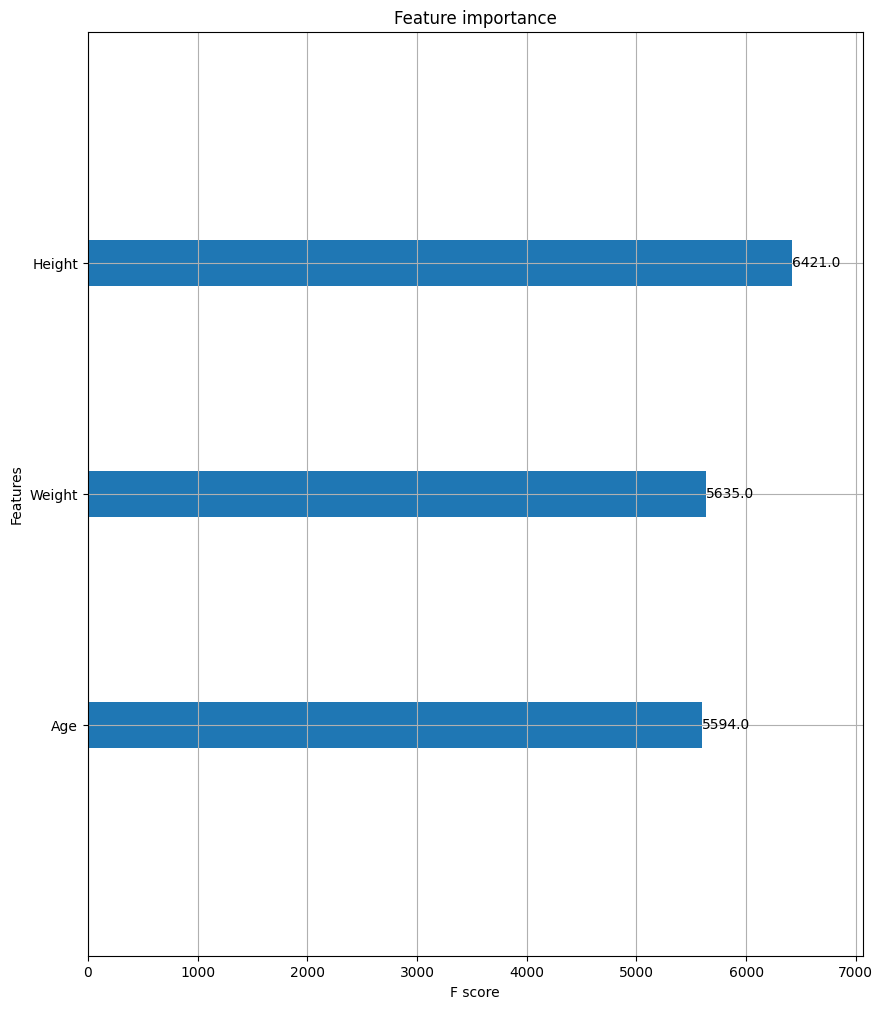

In [74]:
# Feature importance 출력
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

<font color=yellow>
7. Test 예측 결과 생성
</font>

In [75]:
sample = pd.read_csv(os.path.join(cfg.data_path, 'sample_submission.csv'))
print(sample.head())

      id     NObeyesdad
0  20758  Normal_Weight
1  20759  Normal_Weight
2  20760  Normal_Weight
3  20761  Normal_Weight
4  20762  Normal_Weight


In [76]:
# X_sub = df_test.drop(columns=['id'])
X_sub = df_test[['Weight', 'Height', 'Age']]

# X_sub[cat_attribs] = X_sub[cat_attribs].astype('category')

In [77]:
y_pred = xgb_model.predict(X_sub)
result = le.inverse_transform(y_pred)
print(result)

['Obesity_Type_II' 'Overweight_Level_I' 'Obesity_Type_III' ...
 'Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_II']


In [78]:
submission = pd.DataFrame({'id': df_test.id, 'NObeyesdad': result})
submission.to_csv('submission.csv', index=False)